# ALS Analysis

In [12]:
import pandas as pd
import numpy as np
from lenskit.algorithms.item_knn import ItemItem
from lenskit.metrics import topn as lm
%matplotlib inline

## Explicit Parameter Sweep

In [2]:
db_url = 'sqlite:///build/sweep-als-ml-10m.sqlite'

In [3]:
runs = pd.read_sql('runs', db_url)
runs.head()

,index,Partition,PredictTime,TrainTime,features,regularization
0,0,0,13.350378,15.826921,5,0.01
1,0,0,13.391721,14.115965,5,0.05
2,0,0,13.623664,14.159285,5,0.10
3,0,0,13.411846,14.972972,10,0.01
4,0,0,13.403215,14.961558,10,0.05


### Training Time

In [4]:
train_time = runs.groupby(['features', 'regularization']).TrainTime.agg(['mean', 'min', 'max'])
train_time.head()

mean        min        max
features regularization                                 
5        0.01            14.521292  14.095455  15.826921
         0.05            14.183951  14.018807  14.348060
         0.10            14.189823  14.087938  14.281993
10       0.01            15.085923  14.972972  15.200739
         0.05            15.071787  14.961558  15.227893

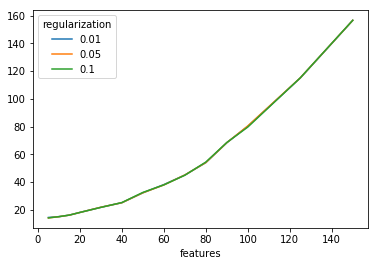

In [5]:
train_time.reset_index().pivot(index='features', columns='regularization', values='mean').plot()

Regularization does not affect training time, but feature count definitely does (as expected).

### Prediction Accuracy

In [4]:
preds = pd.read_sql('predictions', db_url)
preds.head()

,index,user,item,rating,timestamp,prediction,features,regularization
0,321,7,3703,5.0,1049820598,3.887248,5,0.01
1,247,7,593,3.0,1049764435,4.423460,5,0.01
2,291,7,1590,3.0,1050098747,3.044372,5,0.01
3,345,7,5500,3.5,1055038214,3.630372,5,0.01
4,350,7,6273,4.0,1055038104,4.488814,5,0.01


In [5]:
preds['error'] = preds.rating - preds.prediction
preds['sqerr'] = preds.error * preds.error
mse = preds.groupby(['features', 'regularization']).sqerr.mean()
rmse = np.sqrt(mse)
rmse = rmse.reset_index(name='RMSE')
rmse.head()

,features,regularization,RMSE
0,5,0.01,0.875147
1,5,0.05,0.857125
2,5,0.10,0.861759
3,10,0.01,0.894736
4,10,0.05,0.848320


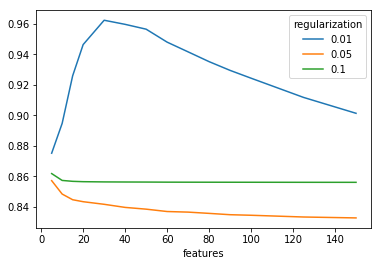

In [6]:
rmse_piv = rmse.pivot(index='features', columns='regularization', values='RMSE')
rmse_piv.plot()

## Implicit Parameter Sweep

In [2]:
db_url = 'sqlite:///build/sweep-als-both-ml-100k.sqlite'

In [3]:
runs = pd.read_sql('runs', db_url)
runs.head()

,index,AlgoStr,Algorithm,Partition,PredictTime,RecTime,RunId,TrainTime,features
0,0,"als.BiasedMF(features=5, regularization=0.1)",BiasedMF,0,0.239520,0.607238,1,2.348789,5
1,0,"als.BiasedMF(features=10, regularization=0.1)",BiasedMF,0,0.228331,0.606916,2,0.437691,10
2,0,"als.BiasedMF(features=15, regularization=0.1)",BiasedMF,0,0.228836,0.626561,3,0.441043,15
3,0,"als.BiasedMF(features=20, regularization=0.1)",BiasedMF,0,0.235252,0.636748,4,0.403580,20
4,0,"als.BiasedMF(features=30, regularization=0.1)",BiasedMF,0,0.233949,0.670511,5,0.435973,30


In [16]:
meta = runs.loc[:, ['RunId', 'Algorithm', 'features']]
meta.head()

,RunId,Algorithm,features
0,1,BiasedMF,5
1,2,BiasedMF,10
2,3,BiasedMF,15
3,4,BiasedMF,20
4,5,BiasedMF,30


### Training Time

In [4]:
train_time = runs.groupby(['Algorithm', 'features']).TrainTime.agg(['mean', 'min', 'max'])
train_time.head()

mean       min       max
Algorithm features                              
BiasedMF  5         0.800076  0.376691  2.348789
          10        0.413155  0.373774  0.487399
          15        0.416160  0.372280  0.463934
          20        0.388998  0.380180  0.403580
          30        0.421176  0.396580  0.452961

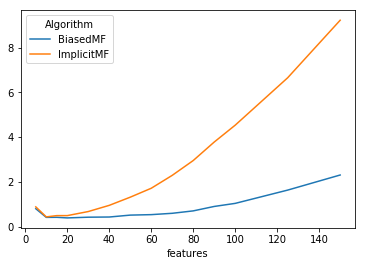

In [5]:
train_time.reset_index().pivot(index='features', columns='Algorithm', values='mean').plot()

### Top-N Accuracy

In [14]:
recs = pd.read_sql('recommendations', db_url)
recs.head()

,index,user,rank,item,score,rating,timestamp,RunId
0,0,6,1,603,4.306980,0.0,NaN,1
1,1,6,2,114,4.276871,0.0,NaN,1
2,2,6,3,654,4.263980,0.0,NaN,1
3,3,6,4,1449,4.260172,0.0,NaN,1
4,4,6,5,657,4.250034,0.0,NaN,1


In [17]:
recs.sort_values(['RunId', 'user', 'rank'], inplace=True)

In [21]:
user_ndcg = recs.groupby(['RunId', 'user']).rating.apply(lm.ndcg).reset_index(name='NDCG')
user_ndcg.head()

,RunId,user,NDCG
0,1,6,0.212746
1,1,7,0.178104
2,1,14,0.000000
3,1,19,0.000000
4,1,20,0.000000


In [24]:
ndcg = pd.merge(meta, user_ndcg).groupby(['Algorithm', 'features']).NDCG.mean().reset_index()
ndcg.head()

,Algorithm,features,NDCG
0,BiasedMF,5,0.145058
1,BiasedMF,10,0.157019
2,BiasedMF,15,0.159552
3,BiasedMF,20,0.163074
4,BiasedMF,30,0.169800


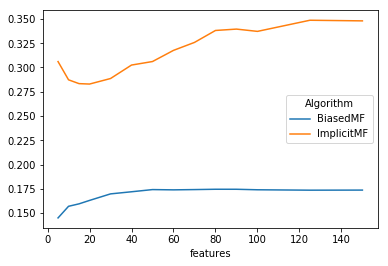

In [25]:
ndcg.pivot(index='features', columns='Algorithm', values='NDCG').plot()

## Training Study

In [ ]:
epochs = pd.read_csv('build/probe-als-ml-10m.csv')

In [ ]:
epochs.plot.scatter(x='epoch', y='rmse')